# Import Packages

In [39]:
import mysql.connector
from mysql.connector import errorcode
import config
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load Data from MySQL

In [2]:
def connect(dbname):
    cnx = mysql.connector.connect(
        host = config.host,
        user = config.user,
        passwd = config.password,
        database = dbname,
        buffered = True
        )
    cursor = cnx.cursor()
    return cnx, cursor

In [3]:
def close_cnx():
    cursor.close()
    cnx.close()

In [323]:
cnx, cursor = connect('colleges')
cursor.execute("""SELECT * FROM ipeds_dir INNER JOIN ipeds_inst_char USING (unitid) INNER JOIN ipeds_ug_headcount USING (unitid) INNER JOIN sc_stud_char USING (unitid)""")
ipeds_data = cursor.fetchall()
ipeds_data_df = pd.DataFrame(ipeds_data)
field_names = [i[0] for i in cursor.description]
ipeds_data_df.columns = field_names
close_cnx()

In [324]:
ipeds_data_df.drop(['year', 'inst_status', 'currently_active_ipeds', 'degree_granting'], axis = 1, inplace = True)

In [325]:
ipeds_data_df = ipeds_data_df[ipeds_data_df['primarily_postsecondary'] == 1]
ipeds_data_df.drop('primarily_postsecondary', axis = 1, inplace = True)

In [326]:
ipeds_data_df.offering_undergrad.value_counts()

1    4064
Name: offering_undergrad, dtype: int64

In [327]:
description = pd.DataFrame(ipeds_data_df.describe())
description = pd.DataFrame(description.loc['std'])
description[description['std'] == 0]

,std
year_deleted,0.0
offering_undergrad,0.0


In [328]:
ipeds_data_df.drop(['offering_undergrad', 'year_deleted'], axis = 1, inplace = True)

In [329]:
ipeds_data_df.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'open_public', 'title_iv_indicator',
       'postsec_public_active', 'postsec_public_active_title_iv',
       'inst_control', 'institution_level', 'inst_category', 'inst_size',
       'sector', 'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_undergrad_2015', 'cc_enroll_2015', 'cc_size_setting_2015',
       'inst_affiliation', 'primary_public_control',
       'occupational_prog_offered', 'academic_prog_offered',
       'cont_prof_prog_offered', 'avocational_prog_offered',
       'remedial_prog_offered', 'secondary_prog_offered', 'assoc_offered',
       'bach_offered', 'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'enrolled_undergrad_fulltime',
     

# Exploratory Data Analysis

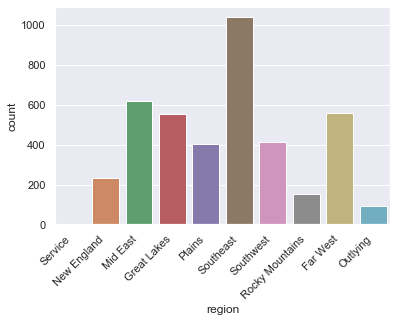

In [330]:
# Consider aggregating regions?
# Drop service schools
sns.set(style="darkgrid")
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'region', data = ipeds_data_df, ax = ax)
ax.set_xticklabels(['Service', 'New England', 'Mid East', 'Great Lakes', 'Plains', 'Southeast', 
                    'Southwest', 'Rocky Mountains', 'Far West', 'Outlying'], rotation = 45, 
                    horizontalalignment = 'right');

# Create Census Bureau Regions

In [331]:
northeast = ['CT', 'MA', 'ME', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
south = ['AL', 'AR', 'DE', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
midwest = ['IA', 'IL', 'IN', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI']
west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NM', 'NV', 'OR', 'UT', 'WA', 'WY']

In [332]:
len(northeast) + len(south) + len(midwest) + len(west)

50

In [333]:
cb_region = []
for state in ipeds_data_df['state_abbr']:
    if state in northeast:
        cb_region.append('Northeast')
    elif state in south:
        cb_region.append('South')
    elif state in midwest:
        cb_region.append('Midwest')
    elif state in west:
        cb_region.append('West')
    else:
        cb_region.append('N/A')

In [334]:
ipeds_data_df['cb_region'] = cb_region

In [335]:
ipeds_data_df.cb_region.value_counts()

South        1404
Midwest       955
West          825
Northeast     776
N/A           104
Name: cb_region, dtype: int64

In [336]:
ipeds_data_df.shape

(4064, 145)

## Subset those in the US (not outlying regions or service)

In [337]:
ipeds_data_us = ipeds_data_df[ipeds_data_df['cb_region'] != 'N/A']
ipeds_data_us.shape

(3960, 145)

# Remove columns with at least 1000 missing rows

In [338]:
ipeds_us_nona = ipeds_data_us.fillna('MISSING')
ipeds_us_nona.replace({-1: 'MISSING', -2: 'MISSING', -3: 'MISSING'}, inplace = True)

In [339]:
ipeds_us_nona.dependent_midincome_pct.value_counts()

MISSING     1545
0.220811      33
0.245583      32
0.326367      29
0.307881      28
0.32134       27
0.27526       21
0.271731      19
0.314905      18
0.30972       16
0.273626      15
0.234488      15
0.22177       12
0.347323      12
0.319183      12
0.238914      12
0.271914      11
0.283078      10
0.3            9
0.199629       8
0.338771       8
0.278775       8
0.285714       8
0.258857       7
0.224886       7
0.349929       7
0.327779       6
0.354478       6
0.306538       6
0.274637       6
            ... 
0.353023       1
0.38642        1
0.252514       1
0.295          1
0.373243       1
0.352117       1
0.38484        1
0.309211       1
0.393346       1
0.234539       1
0.355847       1
0.352672       1
0.305099       1
0.397368       1
0.338216       1
0.397738       1
0.391455       1
0.369198       1
0.31008        1
0.328723       1
0.326223       1
0.346715       1
0.334575       1
0.386207       1
0.446147       1
0.384229       1
0.355446       1
0.375297      

In [340]:
# Find all columns missing more than 10% of data
mean_na = pd.DataFrame(ipeds_us_nona.isin(['MISSING']).mean())
mean_na.reset_index(inplace = True)
mean_na.columns = ['columns', 'prop_MISSING']
col_to_drop = mean_na[mean_na.prop_MISSING > 0.1]

In [341]:
col_to_drop

,columns,prop_MISSING
24,cc_undergrad_2015,1.000000
28,primary_public_control,0.597727
31,cont_prof_prog_offered,0.372475
51,typical_room_charge,0.605556
52,typical_board_charge,0.644949
53,room_board_charge,0.898737
56,religious_affiliation,0.807828
104,dependent_lowincome_pct,0.171465
105,independent_lowincome_pct,0.171465
108,highincome1_pct,0.173485


In [342]:
ipeds_us_vars = ipeds_data_us.drop(col_to_drop['columns'], axis = 1)

In [343]:
ipeds_us_vars.shape

(3960, 115)

In [344]:
mean_neg = pd.DataFrame(ipeds_us_vars.isin([-1, -2, -3]).sum())
mean_neg.reset_index(inplace = True)
mean_neg.columns = ['columns', 'neg']
cols = mean_neg[mean_neg.neg > 0]

In [345]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
ipeds_num = ipeds_us_vars.select_dtypes(include=numerics)

In [346]:
ipeds_nonum = ipeds_us_vars.select_dtypes(exclude = numerics)

In [347]:
ipeds_str = pd.concat([ipeds_us_vars['unitid'], ipeds_nonum], axis = 1)

# Remove rows with missing values (not the best solution)

In [348]:
import numpy as np
ipeds_num_na = ipeds_num.replace({-1: np.nan, -2: np.nan, -3: np.nan})

In [349]:
ipeds_num_nona = ipeds_num_na.dropna()
ipeds_num_nona.shape

(2917, 112)

In [350]:
ipeds_nona_all = ipeds_num_nona.set_index('unitid').join(ipeds_str.set_index('unitid'))

## Remove columns with standard deviation of 0

In [351]:
df_descrip = pd.DataFrame(ipeds_nona_all.describe())
df_descrip = pd.DataFrame(df_descrip.loc['std'])
df_descrip[df_descrip['std'] == 0]

,std
open_public,0.0
postsec_public_active,0.0
postsec_public_active_title_iv,0.0
enrolled_undergrad_fulltime,0.0


In [352]:
ipeds_nona_all.drop(['open_public', 'postsec_public_active', 
                     'postsec_public_active_title_iv', 'enrolled_undergrad_fulltime'], 
                    axis = 1, inplace = True)

In [353]:
ipeds_nona_all.shape

(2917, 110)

# Get Proportions of Race

In [422]:
def get_prop(headcount_str, df):
    new_col = f'headcount_{headcount_str}_Total_prop'
    str_col = f'headcount_{headcount_str}_Total'
    df[new_col] = df[str_col] / df['headcount_total_Total']

In [359]:
get_prop('asn', ipeds_nona_all)
get_prop('blk', ipeds_nona_all)
get_prop('hsp', ipeds_nona_all)
get_prop('hwnpi', ipeds_nona_all)
get_prop('mlt', ipeds_nona_all)
get_prop('nonres', ipeds_nona_all)
get_prop('ntv', ipeds_nona_all)
get_prop('unknown', ipeds_nona_all)
get_prop('wht', ipeds_nona_all)

# Overview Figures

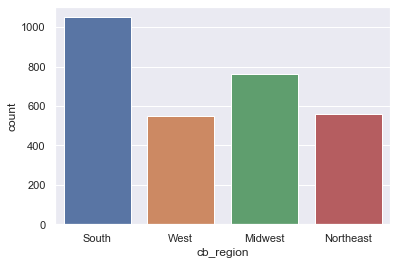

In [304]:
sns.set(style="darkgrid")
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'cb_region', data = ipeds_nona_all, ax = ax)
# ax.set_xticklabels([], rotation = 45, 
#                     horizontalalignment = 'right');

In [420]:
ipeds_nona_all.cb_region.value_counts()

South        1050
Midwest       761
Northeast     559
West          547
Name: cb_region, dtype: int64

1.0    2911
2.0       6
Name: title_iv_indicator, dtype: int64

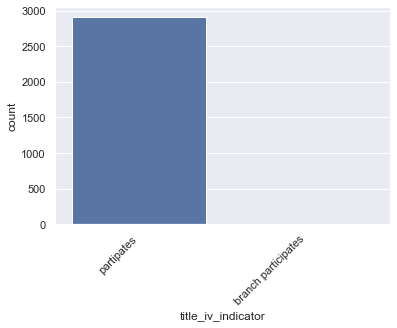

In [305]:
# Consider only keeping those that participate in title iv federal aid program
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'title_iv_indicator', data = ipeds_nona_all, ax = ax)
ax.set_xticklabels(['partipates', 'branch participates'], 
                    rotation = 45, horizontalalignment = 'right');
ipeds_nona_all.title_iv_indicator.value_counts()

4.0    1895
2.0    1022
Name: institution_level, dtype: int64

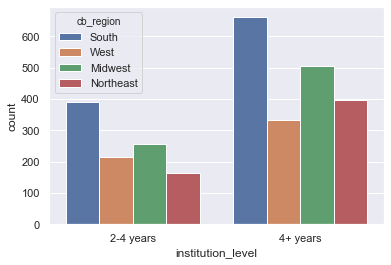

In [309]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'institution_level', hue = 'cb_region', data = ipeds_nona_all, ax = ax)
ax.set_xticklabels(['2-4 years', '4+ years']);
ipeds_nona_all.institution_level.value_counts()

1.0    1444
2.0     990
3.0     483
Name: inst_control, dtype: int64

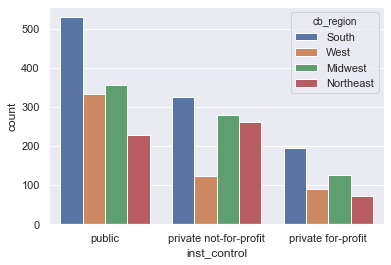

In [308]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_control', hue = 'cb_region', data = ipeds_nona_all, ax = ax)
ax.set_xticklabels(['public', 'private not-for-profit', 'private for-profit']);
ipeds_nona_all.inst_control.value_counts()

2.0    1571
4.0    1023
3.0     322
1.0       1
Name: inst_category, dtype: int64

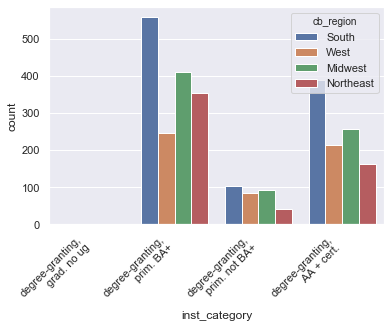

In [312]:
# Consider dropping degree-granting no ug (1), missing (-1), not applicable (-2)
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_category', hue = 'cb_region', data = ipeds_nona_all, ax = ax)
ax.set_xticklabels(['degree-granting,\n grad. no ug', 
                    'degree-granting,\n prim. BA+', 'degree-granting,\n prim. not BA+', 
                    'degree-granting,\n AA + cert.'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_nona_all.inst_category.value_counts()

2.0    1194
1.0     692
3.0     491
4.0     320
5.0     220
Name: inst_size, dtype: int64

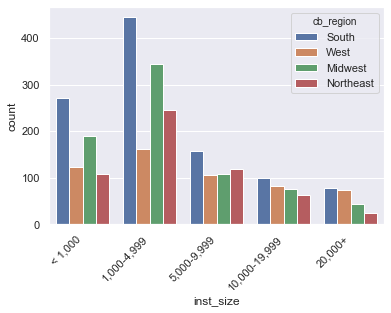

In [315]:
# Consider dropping NA (-2) and missing (-1)
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'inst_size', hue = 'cb_region', data = ipeds_nona_all, ax = ax)
ax.set_xticklabels(['< 1,000', '1,000-4,999', '5,000-9,999', 
                    '10,000-19,999', '20,000+'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_nona_all.inst_size.value_counts()

2.0    945
4.0    800
1.0    644
3.0    306
6.0    177
5.0     45
Name: sector, dtype: int64

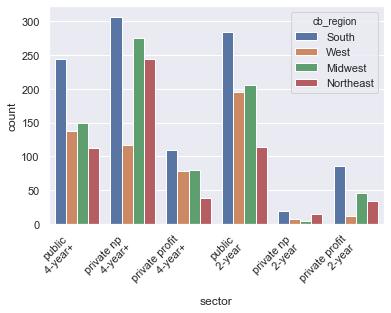

In [317]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'sector', hue = 'cb_region', data = ipeds_nona_all, ax = ax)
ax.set_xticklabels(['public\n 4-year+', 'private np\n 4-year+', 
                    'private profit\n 4-year+', 'public\n 2-year', 'private np\n 2-year', 
                    'private profit\n 2-year'], rotation = 45, 
                    horizontalalignment = 'right');
ipeds_nona_all.sector.value_counts()

0.0    1522
1.0    1395
Name: tuition_varies, dtype: int64

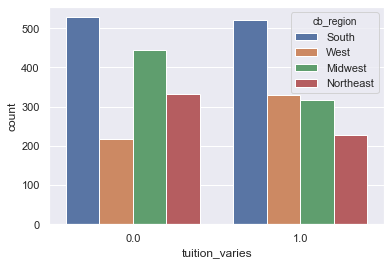

In [421]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'sector', hue = 'cb_region', data = ipeds_nona_all, ax = ax)
# ax.set_xticklabels(['public\n 4-year+', 'private np\n 4-year+', 
#                     'private profit\n 4-year+', 'public\n 2-year', 'private np\n 2-year', 
#                     'private profit\n 2-year'], rotation = 45, 
#                     horizontalalignment = 'right');
ipeds_nona_all.tuition_varies.value_counts()

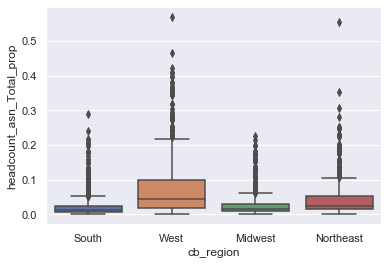

In [364]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_asn_Total_prop', data = ipeds_nona_all, ax = ax)

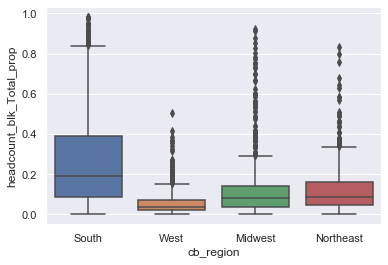

In [365]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_blk_Total_prop', data = ipeds_nona_all, ax = ax)

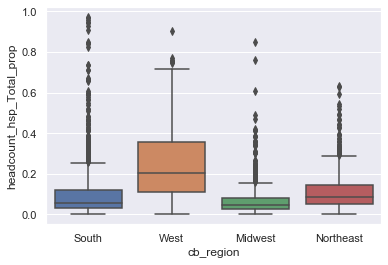

In [366]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_hsp_Total_prop', data = ipeds_nona_all, ax = ax)

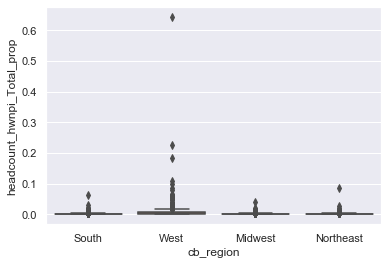

In [367]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_hwnpi_Total_prop', data = ipeds_nona_all, ax = ax)

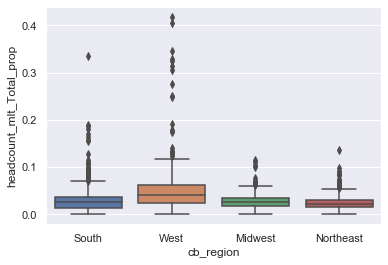

In [368]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_mlt_Total_prop', data = ipeds_nona_all, ax = ax)

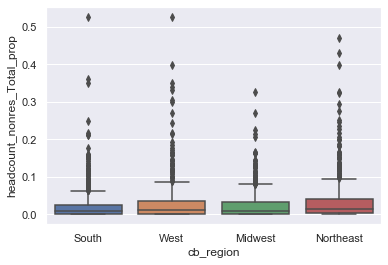

In [369]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_nonres_Total_prop', data = ipeds_nona_all, ax = ax)

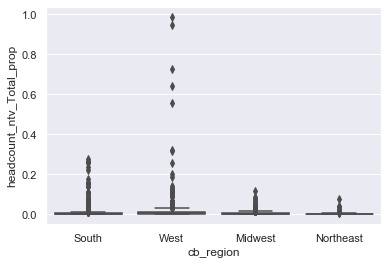

In [370]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_ntv_Total_prop', data = ipeds_nona_all, ax = ax)

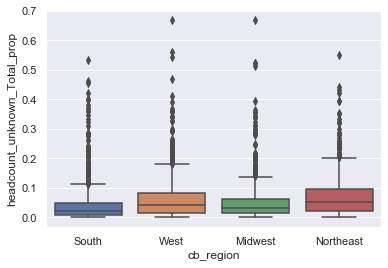

In [371]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_unknown_Total_prop', data = ipeds_nona_all, ax = ax)

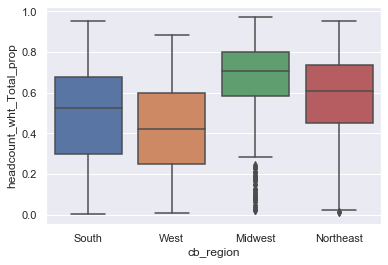

In [372]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'headcount_wht_Total_prop', data = ipeds_nona_all, ax = ax)

In [399]:
ipeds_nona_all.columns.values

array(['region', 'urban_centric_locale', 'title_iv_indicator',
       'inst_control', 'institution_level', 'inst_category', 'inst_size',
       'sector', 'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_varies', 'alt_tuition', 'ap_credit', 'rotc',
   

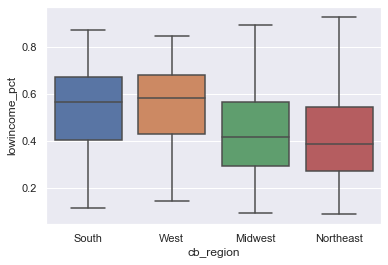

In [410]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'lowincome_pct', data = ipeds_nona_all, ax = ax)

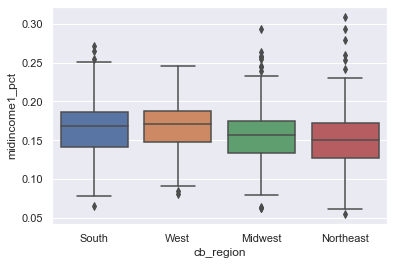

In [411]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'midincome1_pct', data = ipeds_nona_all, ax = ax)

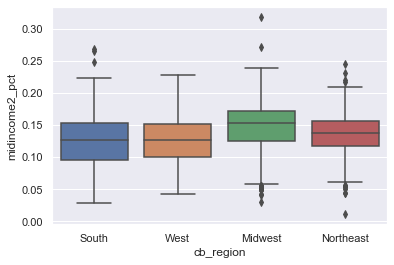

In [412]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'midincome2_pct', data = ipeds_nona_all, ax = ax)

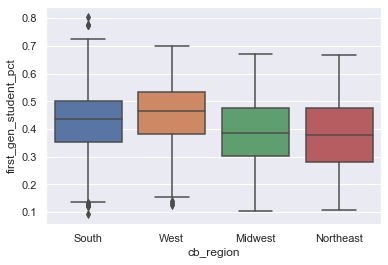

In [413]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'first_gen_student_pct', data = ipeds_nona_all, ax = ax)

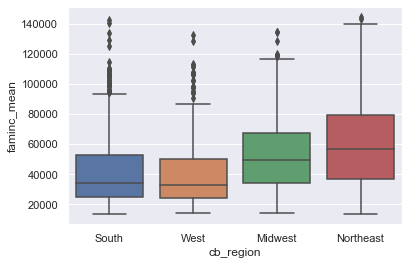

In [414]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'faminc_mean', data = ipeds_nona_all, ax = ax)

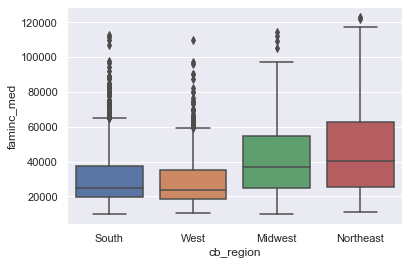

In [415]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'faminc_med', data = ipeds_nona_all, ax = ax)

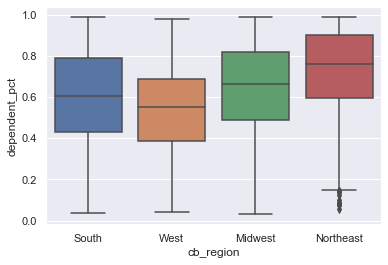

In [416]:
fig = plt.figure()
ax = fig.gca()
sns.boxplot(x = 'cb_region', y = 'dependent_pct', data = ipeds_nona_all, ax = ax)

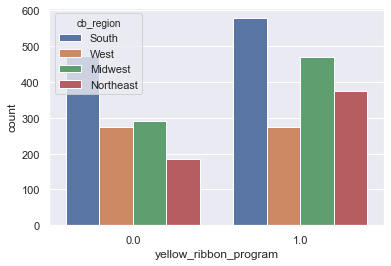

In [418]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'yellow_ribbon_program', hue = 'cb_region', data = ipeds_nona_all, ax = ax)

In [ ]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'oncampus_housing', hue = 'cb_region', data = ipeds_nona_all, ax = ax)

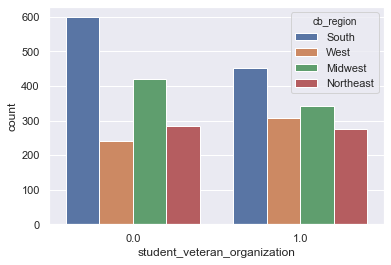

In [404]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'student_veteran_organization', hue = 'cb_region', data = ipeds_nona_all, ax = ax)

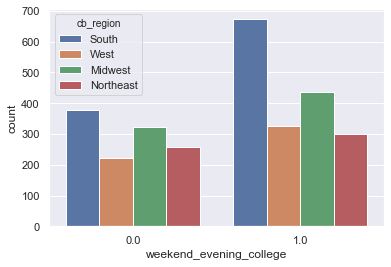

In [408]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'weekend_evening_college', hue = 'cb_region', data = ipeds_nona_all, ax = ax)

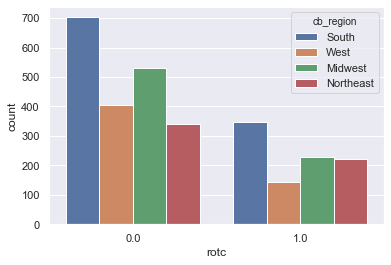

In [409]:
fig = plt.figure()
ax = fig.gca()
sns.countplot(x = 'rotc', hue = 'cb_region', data = ipeds_nona_all, ax = ax)

# Basic Histograms

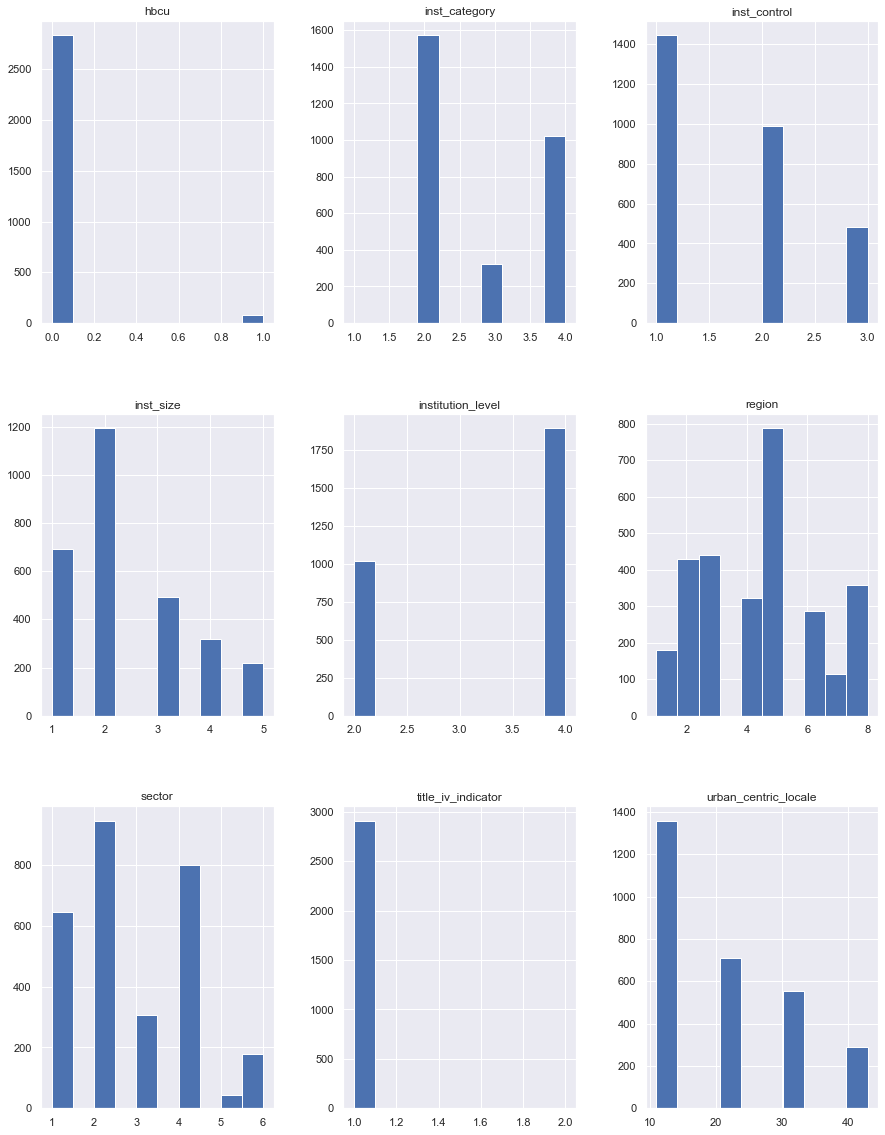

In [387]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 0:9].hist(ax = ax);

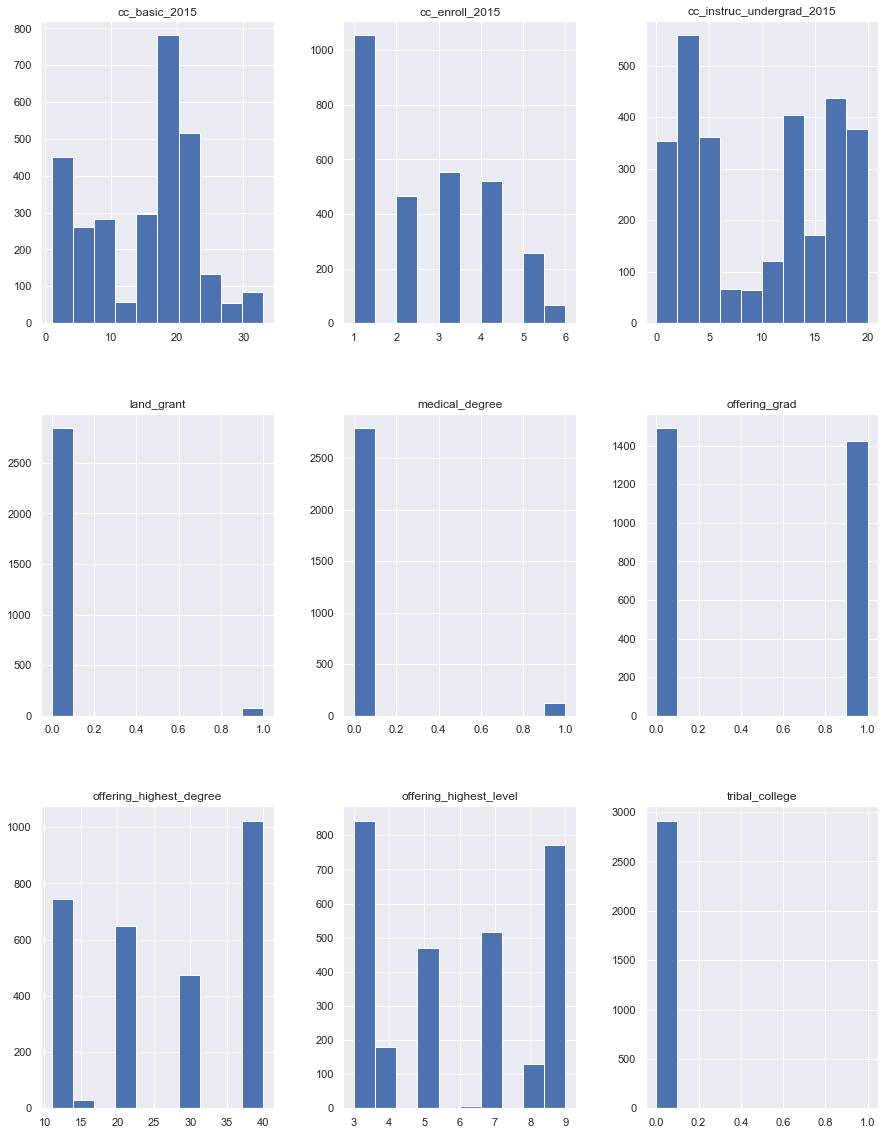

In [388]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 10:19].hist(ax = ax);

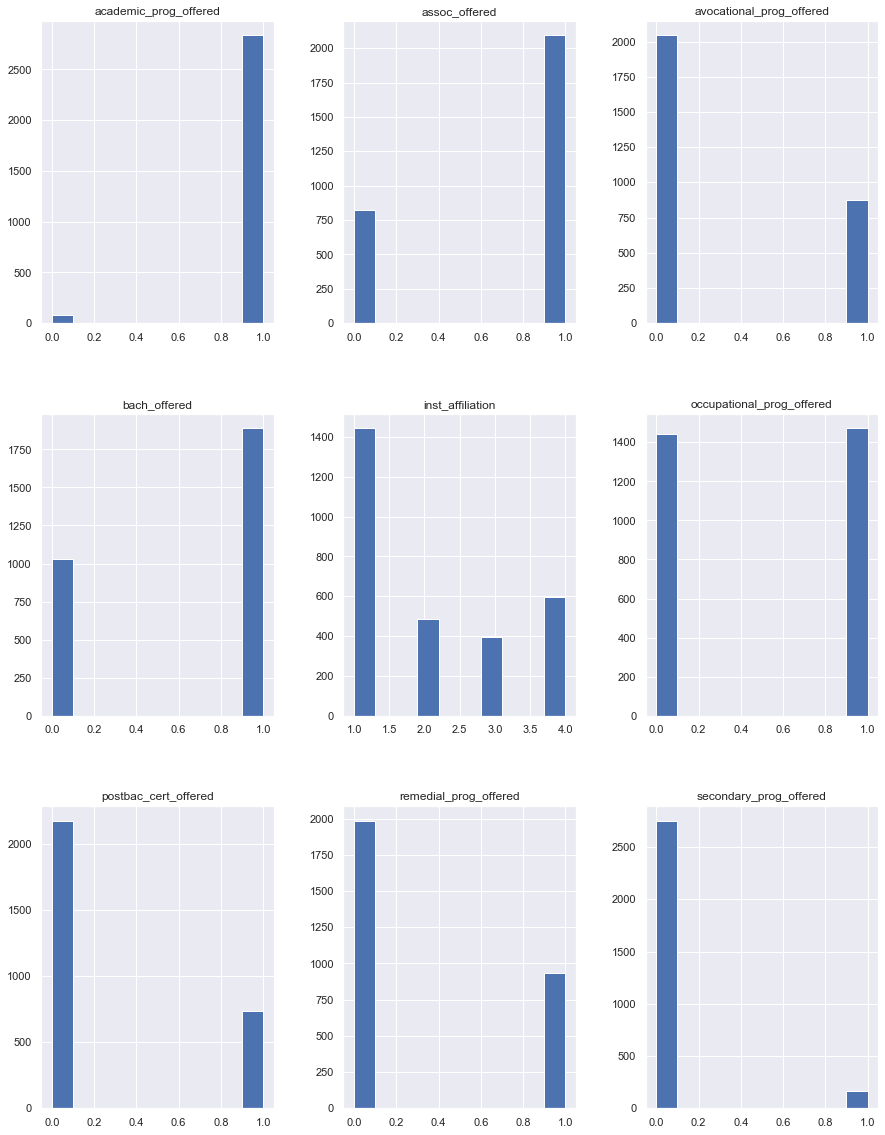

In [389]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 20:29].hist(ax = ax);

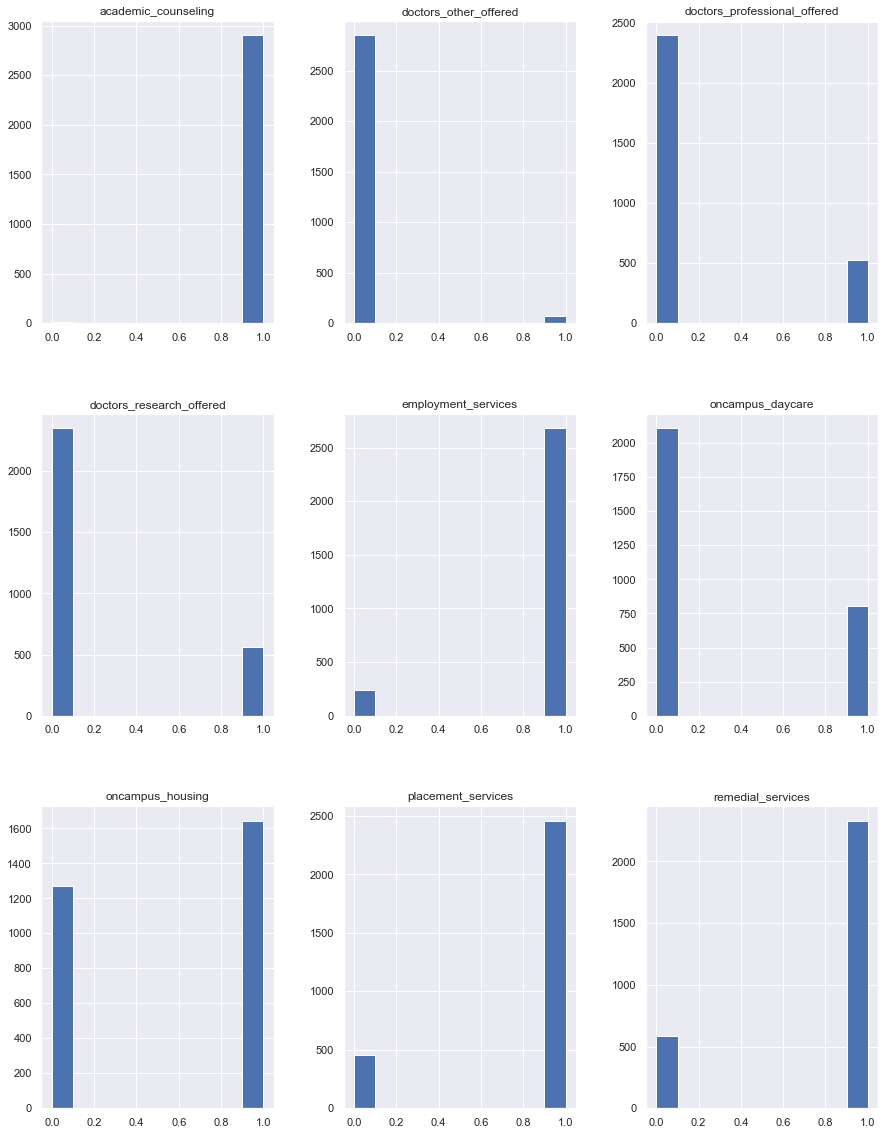

In [390]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 30:39].hist(ax = ax);

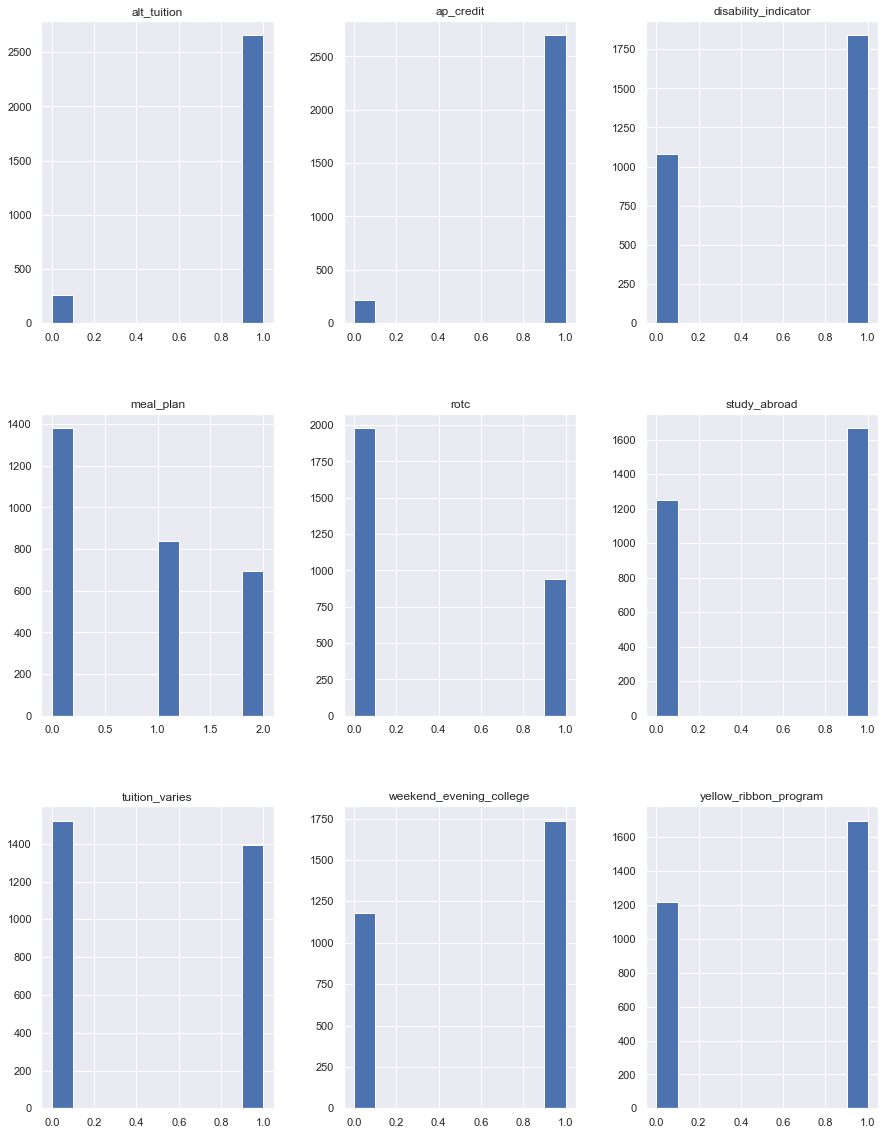

In [391]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 40:49].hist(ax = ax);

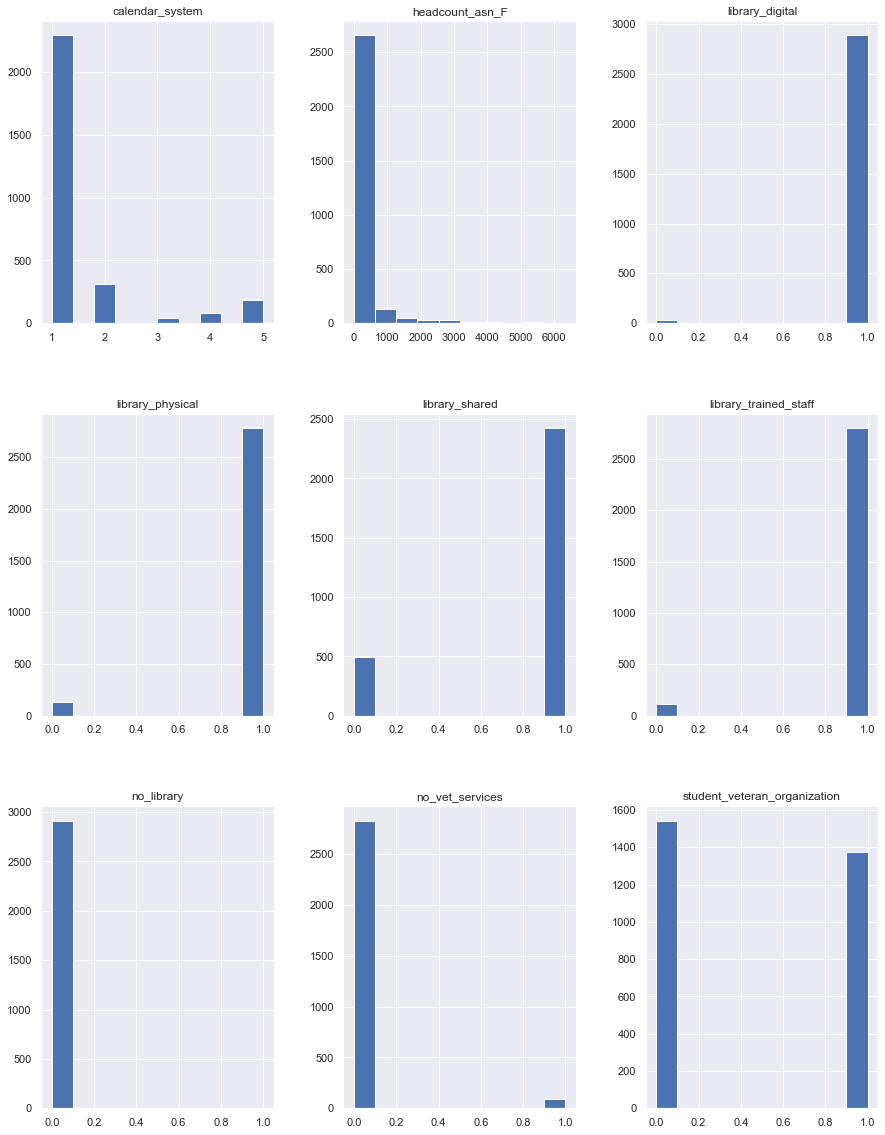

In [392]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 50:59].hist(ax = ax);

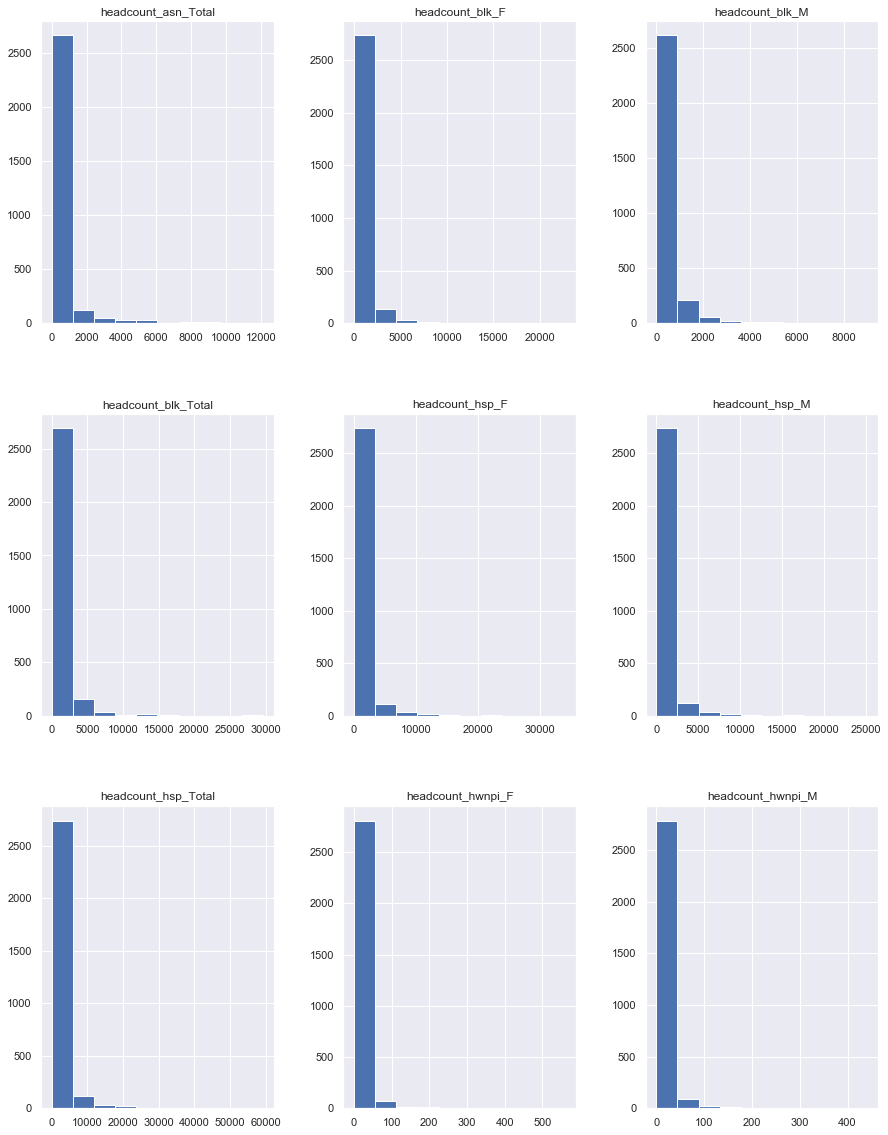

In [393]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 60:69].hist(ax = ax);

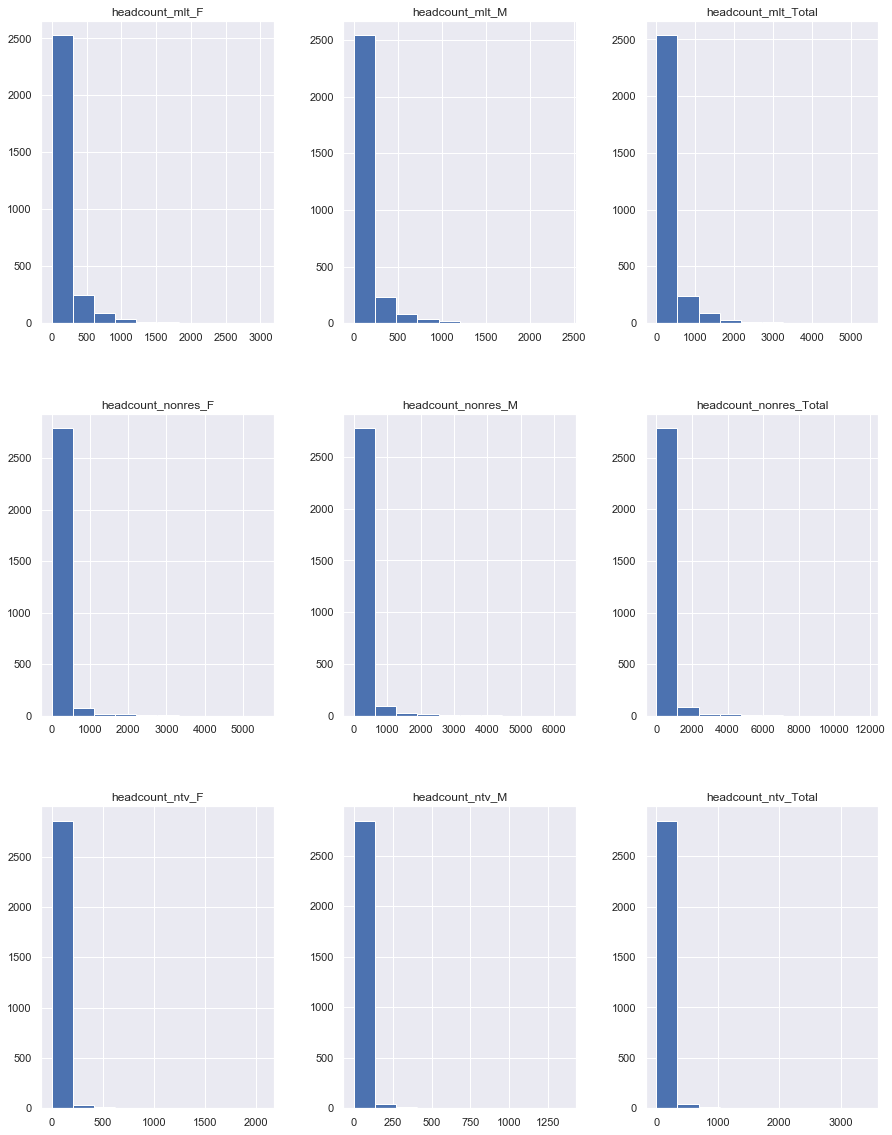

In [394]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 70:79].hist(ax = ax);

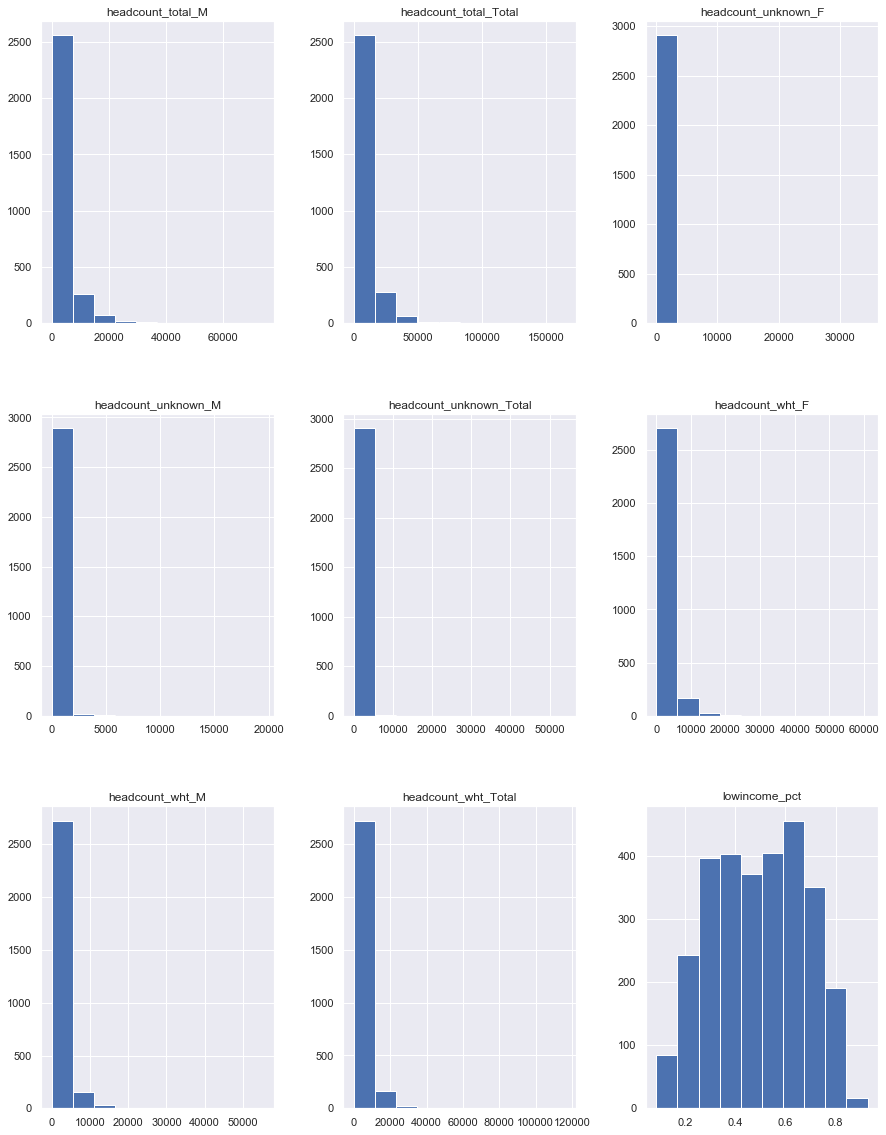

In [395]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 80:89].hist(ax = ax);

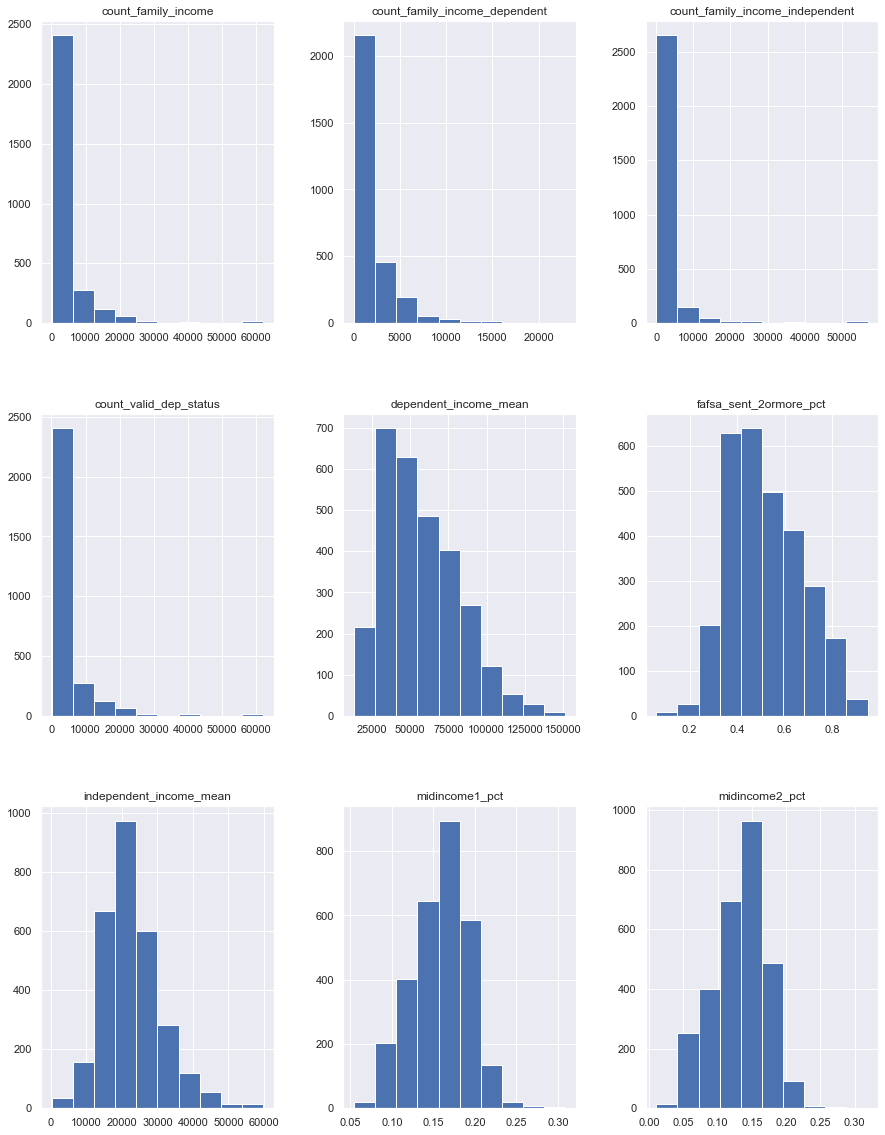

In [396]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 90:99].hist(ax = ax);

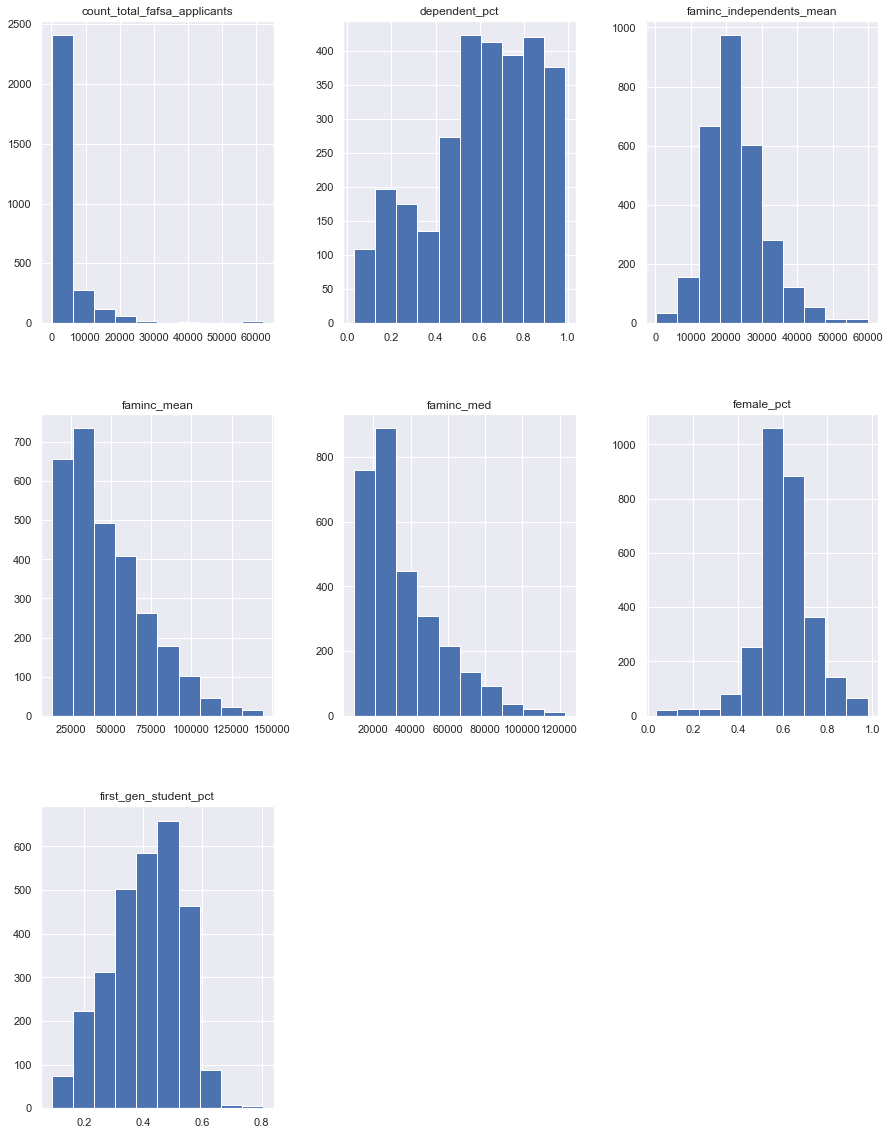

In [397]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 100:109].hist(ax = ax);

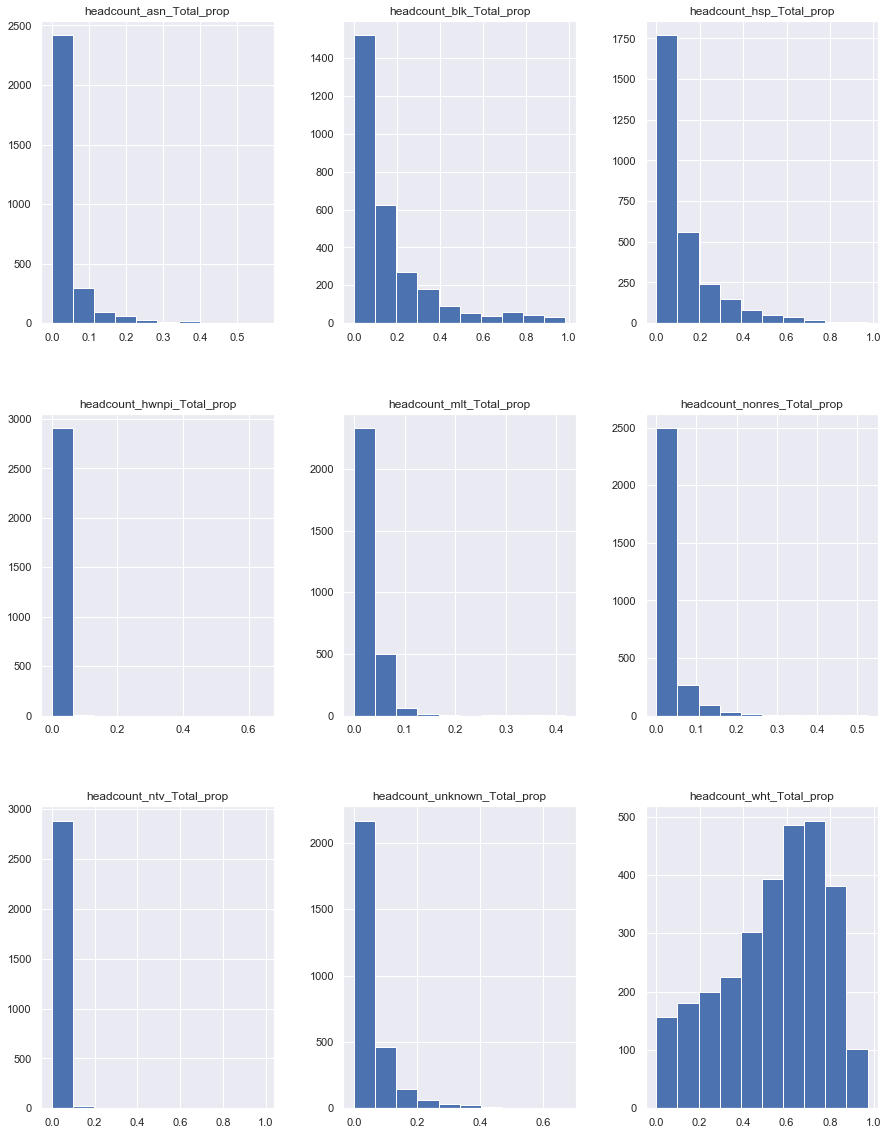

In [398]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
ipeds_nona_all.iloc[:, 110:].hist(ax = ax);

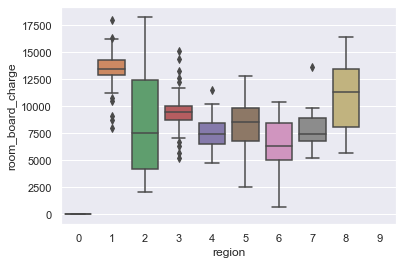

In [38]:
sns.boxplot(x = 'region', y = 'room_board_charge', data = ipeds_data_df)